## Data Science Capstone Project

# Stock Price Prediction Using LSTM Model

 In this article I will walk through how to build an LSTM-based RNN 
 (Recurrent Neural Network) to predict CIMB Stock which is split into 7 parts

## 1. Problem Statement
Using the data. The task is to predict the future stock price using the current stock price
and compare the various optimization methods to increase accuracy overall or to do batch training
to predict future prices 1 day, 3 day in the future for trends to plan for stock purchase or sale
To Capture the trends and to test against a few trading strategies on whether to buy or sell a stock

## 2. Data Preprocessing
The data is taken from Bursa Malaysia using a script to mimic a query
from backend to get the stock data in json format.
Data Normalization tested: StandardScaler,MinMaxScaler and No Normalization but removal of negative correlated features
Feature expansion is also explored using additional technical indicators
Data Splitting methods to test whether different ratios will help prediction accuracy    

## 3. Model Building, selection, comparison
Several Models are available, Linear Regression to predict using already existing data, but its not useable. 
Popular model is LSTM which is can be customizable. 
Layers, Normal Layering, Bidirectional Layer, learning rate, batch size, dropout and regularization
L1 and L2, activation functions, early stopping with cross validation and BatchNormalization

## 4. Model Compiling, Fitting, Prediction and Visualization
The best performing model is compiled and fitted, the predictions are made and then
visualized on a timeseries plot and the accuracy is calculated

## 5. Optimizing and Redo of steps 3-7 
Features will be removed and model parameters will be tuned to get a higher accuracy 
for 1 day, 3 day

## 6. Testing of trading strategies against time
Once a high accuracy predictor is made, we will use it to give guidance on whether to buy or not
and compare this test with simple trading strategies such as moving average comparison and RSI, 
Fibbonaci band trading strategy against time.

## 7. Limitations, Improvements and Suggestions for future testing
Suggestions:
LSTM Models can be linked with CNN for feature selection for a hybrid model
Including Sentiment Analysis that would affect stock prices
Model tuning takes a long time so identifying and seeing the model training data helps to identify
what is the problem and potentially what to try next to optimize the model to help reduce hyperparameter testing time
you can use KerasRegressor to sequentially test a range of parameters
Upgrade computer specifications


In [230]:
#Import Libraries and data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
stock_data = pd.read_excel('./latest_cimb_test.xlsx', index_col='Date')
stock_data.head()

#CIMB data from September 2018 until september 2023 with total of 1134 rows of data

,ID,Name,Open,High,Low,Close,Volume
Date,,,,,,,
20180924,1023,CIMB,6.02,6.06,6.02,6.03,17108800
20180925,1023,CIMB,6.02,6.02,5.99,6.00,24703500
20180926,1023,CIMB,6.01,6.08,6.00,6.04,14643900
20180927,1023,CIMB,6.04,6.06,6.01,6.03,9278500
20180928,1023,CIMB,6.05,6.08,5.94,6.01,11639700


In [151]:
# Transform and calculate additional datapoints to feed into model

#Simple Moving Average (SMA) Calculation
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()
stock_data['SMA_8'] = stock_data['Close'].rolling(window=8).mean()
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['SMA_40'] = stock_data['Close'].rolling(window=40).mean()

# Average True Range (ATR) Calculation
stock_data['high-low'] = stock_data['High'] - stock_data['Low']
stock_data['high-close'] = abs(stock_data['High'] - stock_data['Close'].shift())
stock_data['low-close'] = abs(stock_data['Low'] - stock_data['Close'].shift())
stock_data['true_range'] = stock_data[['high-low', 'high-close', 'low-close']].max(axis=1)
stock_data['ATR'] = stock_data['true_range'].rolling(window=14).mean()

#Relative Strength Index (RSI) Calculation
delta = stock_data['Close'].diff()
up = delta.where(delta > 0, 0)
down = -delta.where(delta < 0, 0)
avg_gain = up.rolling(window=14).mean()
avg_loss = down.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

#Fibonacci Calculation, there are upper and lower bands of fibonacci bands to calculate
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Upper_fib_2618'] = stock_data['SMA_50'] + stock_data['ATR'] * 2.618
stock_data['Upper_fib_4236'] = stock_data['SMA_50'] + stock_data['ATR'] * 4.236
stock_data['Lower_fib_2618'] = stock_data['SMA_50'] - stock_data['ATR'] * 2.618
stock_data['Lower_fib_4236'] = stock_data['SMA_50'] - stock_data['ATR'] * 4.236
stock_data['Upper_fib_1618'] = stock_data['SMA_50'] + stock_data['ATR'] * 1.618
stock_data['Lower_fib_1618'] = stock_data['SMA_50'] - stock_data['ATR'] * 1.618
stock_data['Upper_fib_0618'] = stock_data['SMA_50'] + stock_data['ATR'] * 0.618
stock_data['Lower_fib_0618'] = stock_data['SMA_50'] - stock_data['ATR'] * 0.618

# Calculate %K Line and %D Line Stochastic Oscillator (Something to input into next time)
#stock_data['Lowest_Low'] = min(stock_data['Low'].rolling(window=14))
#stock_data['Highest_High'] = max(stock_data['High'].rolling(window=14))
#stock_data['%K'] = stock_data['Close']
#%K = [(Current Close - Lowest Low) / (Highest High - Lowest Low)] * 100 for each day in the 14-day period.
#%D line by taking the 3-day simple moving average (SMA) of %K. 
#For example, to calculate %D for the 14th day, you would average the %K values for the 14th, 13th, and 12th days.

#Remove Rows with NaN values
data_only = stock_data[~stock_data.isna().any(axis=1)]
data_only.count()

#Sets a target 
target_y = data_only['Close']
#Splits out Non Values to get the features
X_feat = data_only.drop(['ID', 'Name'], axis=1)
X_feat_sc = X_feat
X_feat


,Open,High,Low,Close,Volume,SMA_20,high-low,high-close,low-close,true_range,...,Lower_fib_4236,SMA_30,SMA_40,SMA_10,SMA_5,SMA_8,Upper_fib_1618,Lower_fib_1618,Upper_fib_0618,Lower_fib_0618
Date,,,,,,,,,,,,,,,,,,,,,
20181204,5.80,5.89,5.74,5.81,9736900,5.6745,0.15,0.01,0.16,0.16,...,5.318060,5.679333,5.74875,5.739,5.814,5.76000,5.991270,5.619130,5.876270,5.734130
20181205,5.75,5.81,5.72,5.80,7594800,5.6805,0.09,0.00,0.09,0.09,...,5.304383,5.673333,5.74275,5.753,5.824,5.78125,5.990137,5.611063,5.872994,5.728206
20181206,5.74,5.85,5.72,5.80,7127200,5.6865,0.13,0.05,0.08,0.13,...,5.300383,5.675000,5.73675,5.768,5.814,5.79625,5.986137,5.607063,5.868994,5.724206
20181207,5.78,5.82,5.74,5.78,6265100,5.6910,0.08,0.02,0.06,0.08,...,5.304260,5.677667,5.73525,5.783,5.818,5.80625,5.977470,5.605330,5.862470,5.720330
20181210,5.77,5.77,5.64,5.65,6568600,5.6950,0.13,0.01,0.14,0.14,...,5.290609,5.680000,5.73500,5.780,5.768,5.79375,5.972181,5.595419,5.855753,5.711847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230920,5.58,5.64,5.55,5.62,10520600,5.6795,0.09,0.11,0.20,0.20,...,5.198566,5.664667,5.62600,5.714,5.720,5.71375,5.691974,5.419226,5.607689,5.503511
20230921,5.63,5.64,5.57,5.59,13143300,5.6800,0.07,0.02,0.05,0.07,...,5.230371,5.662667,5.62875,5.699,5.700,5.69875,5.690329,5.436071,5.611757,5.514643
20230922,5.58,5.62,5.56,5.59,8715000,5.6805,0.06,0.03,0.03,0.06,...,5.234746,5.660333,5.63100,5.689,5.662,5.68500,5.698884,5.442316,5.619599,5.521601


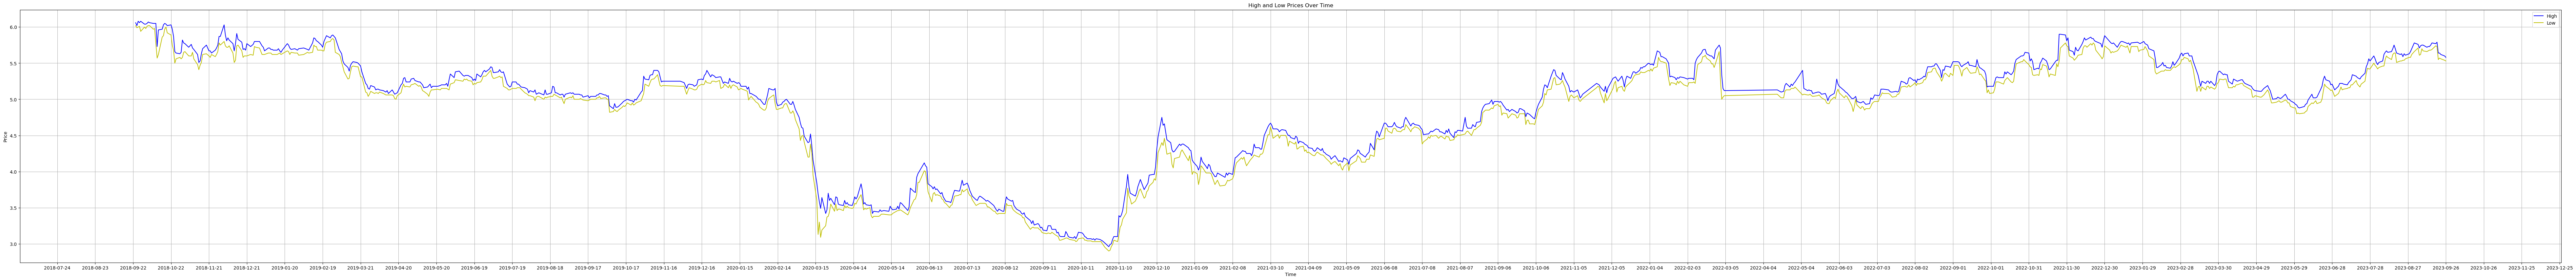

In [231]:
#Plotting High and Low Stock Price points
fig, ax = plt.subplots(figsize=(100,10))
stock_data['Date'] = pd.to_datetime(stock_data.index, format='%Y%m%d')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax.plot(stock_data['Date'], stock_data['High'], linestyle='-', color='b', label='High')
ax.plot(stock_data['Date'], stock_data['Low'], linestyle='-', color='y', label='Low')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('High and Low Prices Over Time')
ax.legend()
plt.grid(True)
plt.show()

In [152]:
X_feat.corr()

#Here SMA_20, SMA_50, fibb bands, Open, High, Low have the highest correlations. But we will include everything to test first

,Open,High,Low,Close,Volume,SMA_20,high-low,high-close,low-close,true_range,...,Lower_fib_4236,SMA_30,SMA_40,SMA_10,SMA_5,SMA_8,Upper_fib_1618,Lower_fib_1618,Upper_fib_0618,Lower_fib_0618
Open,1.000000,0.998085,0.998341,0.996558,-0.175837,0.975413,-0.037569,-0.098631,-0.024209,-0.071088,...,0.918531,0.960489,0.944327,0.990105,0.996890,0.992923,0.922559,0.928065,0.926426,0.928511
High,0.998085,1.000000,0.997556,0.998504,-0.151010,0.974475,0.000997,-0.046108,-0.033368,-0.034664,...,0.914398,0.959457,0.943053,0.989237,0.996156,0.992036,0.922324,0.925616,0.925498,0.926735
Low,0.998341,0.997556,1.000000,0.998319,-0.192114,0.974178,-0.068872,-0.087554,-0.070709,-0.101697,...,0.921517,0.959596,0.943841,0.988740,0.995735,0.991551,0.921229,0.929173,0.925856,0.928874
Close,0.996558,0.998504,0.998319,1.000000,-0.169742,0.972127,-0.031274,-0.049377,-0.067352,-0.066294,...,0.914728,0.956859,0.940373,0.987227,0.994762,0.990163,0.918305,0.924031,0.922231,0.924400
Volume,-0.175837,-0.151010,-0.192114,-0.169742,1.000000,-0.180404,0.593459,0.438539,0.311726,0.604504,...,-0.226009,-0.183685,-0.182428,-0.175542,-0.172665,-0.174723,-0.156634,-0.197331,-0.169728,-0.185303
SMA_20,0.975413,0.974475,0.974178,0.972127,-0.180404,1.000000,-0.028870,-0.085275,-0.000748,-0.050675,...,0.954579,0.994876,0.984385,0.992374,0.982816,0.989021,0.968522,0.968789,0.970858,0.970935
high-low,-0.037569,0.000997,-0.068872,-0.031274,0.593459,-0.028870,1.000000,0.594784,0.535598,0.960630,...,-0.132960,-0.034589,-0.043323,-0.026492,-0.027824,-0.026764,-0.015670,-0.082371,-0.036570,-0.062103
high-close,-0.098631,-0.046108,-0.087554,-0.049377,0.438539,-0.085275,0.594784,1.000000,-0.166534,0.632871,...,-0.131285,-0.081185,-0.080082,-0.091083,-0.093139,-0.092984,-0.055313,-0.098898,-0.069075,-0.085758
low-close,-0.024209,-0.033368,-0.070709,-0.067352,0.311726,-0.000748,0.535598,-0.166534,1.000000,0.626128,...,-0.072940,-0.003516,-0.007308,-0.003428,-0.011334,-0.005017,0.013316,-0.035526,-0.001931,-0.020628
true_range,-0.071088,-0.034664,-0.101697,-0.066294,0.604504,-0.050675,0.960630,0.632871,0.626128,1.000000,...,-0.151191,-0.052780,-0.058033,-0.053317,-0.058398,-0.054987,-0.025224,-0.096930,-0.047712,-0.075161


In [19]:
#Normalization and Splitting of data for predictions
#No Normalization
X_no_norm = X_feat
training_size = round(len(X_no_norm)*0.8)
train_data_no_norm = X_no_norm[:training_size]
test_data_no_norm = X_no_norm[training_size:]
target_no_norm_train, feature_no_norm_train = (train_data_no_norm['Close'], train_data_no_norm.drop(['Close'], axis = 1)) 
target_no_norm_test, feature_no_norm_test = (test_data_no_norm['Close'], test_data_no_norm.drop(['Close'], axis = 1)) 
print(X_no_norm, target_no_norm_train.shape, feature_no_norm_train.shape, target_no_norm_test.shape, feature_no_norm_test.shape)


          Open  High   Low  Close    Volume  SMA_20  high-low  high-close  \
Date                                                                        
20181204  5.80  5.89  5.74   5.81   9736900  5.6745      0.15        0.01   
20181205  5.75  5.81  5.72   5.80   7594800  5.6805      0.09        0.00   
20181206  5.74  5.85  5.72   5.80   7127200  5.6865      0.13        0.05   
20181207  5.78  5.82  5.74   5.78   6265100  5.6910      0.08        0.02   
20181210  5.77  5.77  5.64   5.65   6568600  5.6950      0.13        0.01   
...        ...   ...   ...    ...       ...     ...       ...         ...   
20230920  5.58  5.64  5.55   5.62  10520600  5.6795      0.09        0.11   
20230921  5.63  5.64  5.57   5.59  13143300  5.6800      0.07        0.02   
20230922  5.58  5.62  5.56   5.59   8715000  5.6805      0.06        0.03   
20230925  5.59  5.60  5.54   5.54   7969300  5.6770      0.06        0.01   
20230926  5.54  5.58  5.53   5.56   3452200  5.6750      0.05        0.04   

In [39]:
# Getting the TimeScale and test output for plotting
timescale = target_no_norm_test.index

# Change the format of the date
timescale_list = pd.to_datetime(timescale, format='%Y%m%d')
timescale_list


DatetimeIndex(['2022-10-20', '2022-10-21', '2022-10-25', '2022-10-26',
               '2022-10-27', '2022-10-28', '2022-10-31', '2022-11-01',
               '2022-11-02', '2022-11-03',
               ...
               '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-18',
               '2023-09-19', '2023-09-20', '2023-09-21', '2023-09-22',
               '2023-09-25', '2023-09-26'],
              dtype='datetime64[ns]', name='Date', length=227, freq=None)

Model Coefficients: [-5.32090919e-01  7.52594397e-01  7.28329853e-01 -3.67739201e-11
  7.39618009e-02  2.42645468e-02 -3.14908719e-02 -3.99472970e-02
 -2.35868111e-02 -6.35623557e-04  6.94723614e-04 -5.31731265e-03
 -6.98137512e-03 -8.00981403e-03 -3.65325018e-03 -2.62481126e-03]
Mean Absolute Error: 0.017925905076984463
Coefficient of Determination: 0.992653957298996


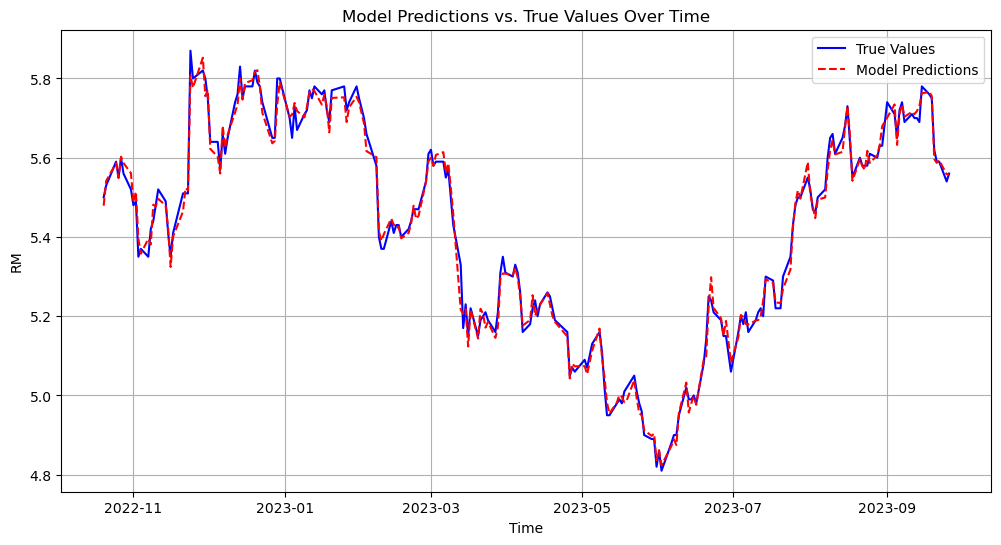

In [41]:
#Model Modelling
lr = LinearRegression()
lr.fit(feature_no_norm_train ,target_no_norm_train)
y_pred_lr = lr.predict(feature_no_norm_test)
# Create the plot and check accuracy
print("Model Coefficients:", lr.coef_)
print("Mean Absolute Error:", mean_absolute_error(target_no_norm_test, y_pred_lr))
print("Coefficient of Determination:", r2_score(target_no_norm_test, y_pred_lr))
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_no_norm_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_pred_lr, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# LSTM Model 50 layers with dropout 2x sets to predict the output that we want
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(feature_no_norm_train.shape[1], 1), activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics =['mean_absolute_error'])
lstm.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 16, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 16, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
454/454 - 15s - loss: 8.1423 - mean_absolute_error: 2.2884 - 15s/epoch - 33ms/step
Epoch 2/30
454/454 - 6s - loss: 0.6554 - mean_absolute_error: 0.6200 - 6s/epoch - 13ms/step
Epoch 3/30
454/454 - 7s - loss: 0.5743 - mean_absolute_error: 0.5858 - 7s/epoch - 14ms/step
Epoch 4/30
454/454 - 6s - loss: 0.4638 - mean_absolute_error: 0.5258 - 6s/epoch - 13ms/step
Epoch 5/30
454/454 - 6s - loss: 0.4864 - mean_absolute_error: 0.5396 - 6s/epoch - 14ms/step
Epoch 6/30
454/454 - 7s - loss: 0.4557 - mean_absolute_error: 0.4987 - 7s/epoch - 14ms/step
Epoch 7/30
454/454 - 6s - loss: 0.4263 - mean_absolute_error: 0.5109 - 6s/epoch - 14ms/step
Epoch 8/30
454/454 - 7s - loss: 0.4290 - mean_absolute_error: 0.5077 - 7s/epoch - 16ms/step
Epoch 9/30
454/454 - 6s - loss: 0.3380 - mean_absolute_error: 0.4481 - 6s/epoch - 14ms/step
Epoch 10/30
454/454 - 7s - loss: 0.6923 - mean_absolute_error: 0.6462 - 7s/epoch - 16ms/step
Epoch 11/30
454/454 - 7s - loss: 0.6640 - mean_absolute_error: 0.6301 - 7s/ep

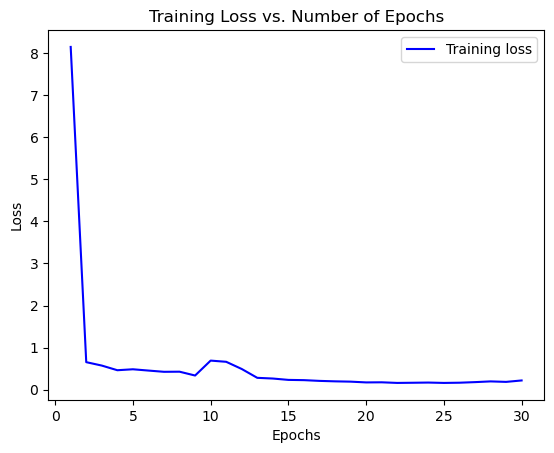

In [66]:
#Try to fit this simple model to the training data
history = lstm.fit(feature_no_norm_train ,target_no_norm_train, epochs=30, batch_size=2, verbose=2, shuffle=False)

# Assuming 'history' contains the training history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
#Predict the output
y_pred_lstm = lstm.predict(feature_no_norm_test)
print(y_pred_lstm, y_pred_lstm.shape)

8/8 [==============================] - 1s 9ms/step
[[5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 [5.367915]
 

RMSE:  0.27573589494025225
MAPE:  0.04487258433197577
Mean Absolute Error: 0.24285443713486454
Coefficient of Determination: -0.03791562881011612


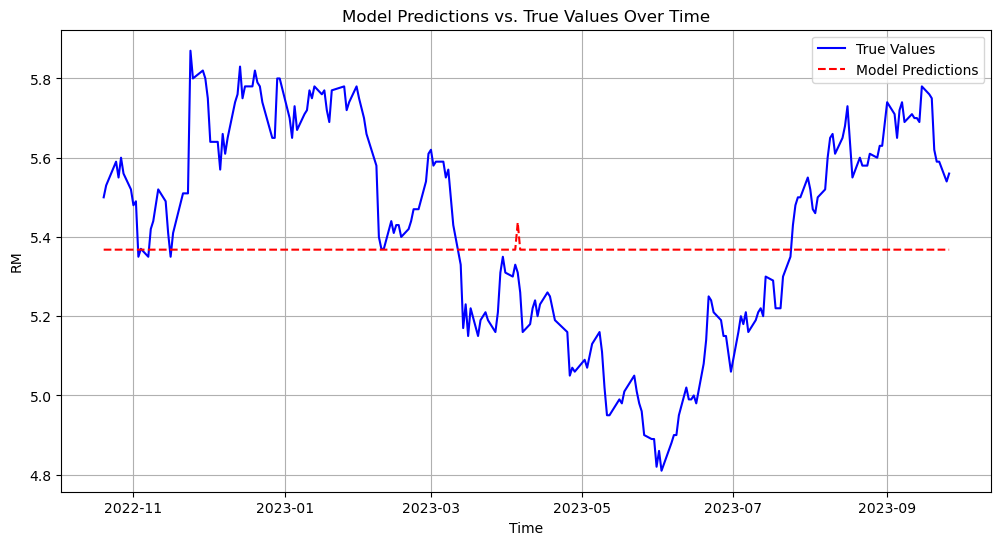

In [68]:
# Create the plot and check accuracy
rmse = mean_squared_error(target_no_norm_test, y_pred_lstm, squared=False)
mape = mean_absolute_percentage_error(target_no_norm_test, y_pred_lstm)
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("Mean Absolute Error:", mean_absolute_error(target_no_norm_test, y_pred_lstm))
print("Coefficient of Determination:", r2_score(target_no_norm_test, y_pred_lstm))
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_no_norm_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_pred_lstm, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Logistic Regression without Normalization is 
Mean Absolute Error: 0.017925905076984463

Coefficient of Determination: 0.992653957298996

# While LSTM models without Normalization is
 Mean Absolute Error: 0.24285443713486454

Coefficient of Determination: -0.03791562881011612

When you want to reverse the normalization, it has to be the same shape as the original input that you normalized,
but because after going through the model, the shape will change so we only normalize features separated from target
and target is not normalized as there is no way to normalize it back unless we normalize it separately

In [97]:
#MinMaxScaler Normalization
X_minmax = X_feat
training_size = round(len(X_minmax)* 0.8)
train_data_minmax = X_minmax[:training_size]
test_data_minmax = X_minmax[training_size:]
target_minmax_train, feature_minmax_train = (train_data_minmax['Close'], train_data_minmax.drop(['Close'], axis = 1)) 
target_minmax_test, feature_minmax_test = (test_data_minmax['Close'], test_data_minmax.drop(['Close'], axis = 1)) 
print(X_minmax, target_minmax_train.shape, feature_minmax_train.shape, target_minmax_test.shape, feature_minmax_test.shape)

#Standard Scaler Normalization
X_scaler = X_feat
training_size = round(len(X_scaler)* 0.8)
train_data_sc = X_scaler[:training_size]
test_data_sc = X_scaler[training_size:]
target_sc_train, feature_sc_train = (train_data_sc['Close'], train_data_sc.drop(['Close'], axis = 1)) 
target_sc_test, feature_sc_test = (test_data_sc['Close'], test_data_sc.drop(['Close'], axis = 1)) 
print(X_scaler, target_sc_train.shape, feature_sc_train.shape, target_sc_test.shape, feature_sc_test.shape)


          Open  High   Low  Close    Volume  SMA_20  high-low  high-close  \
Date                                                                        
20181204  5.80  5.89  5.74   5.81   9736900  5.6745      0.15        0.01   
20181205  5.75  5.81  5.72   5.80   7594800  5.6805      0.09        0.00   
20181206  5.74  5.85  5.72   5.80   7127200  5.6865      0.13        0.05   
20181207  5.78  5.82  5.74   5.78   6265100  5.6910      0.08        0.02   
20181210  5.77  5.77  5.64   5.65   6568600  5.6950      0.13        0.01   
...        ...   ...   ...    ...       ...     ...       ...         ...   
20230920  5.58  5.64  5.55   5.62  10520600  5.6795      0.09        0.11   
20230921  5.63  5.64  5.57   5.59  13143300  5.6800      0.07        0.02   
20230922  5.58  5.62  5.56   5.59   8715000  5.6805      0.06        0.03   
20230925  5.59  5.60  5.54   5.54   7969300  5.6770      0.06        0.01   
20230926  5.54  5.58  5.53   5.56   3452200  5.6750      0.05        0.04   

In [84]:
ms_feature_train = MinMaxScaler()
feature_minmax_train[feature_minmax_train.columns] = ms_feature_train.fit_transform(feature_minmax_train)
ms_feature_test = MinMaxScaler()
feature_minmax_test[feature_minmax_test.columns] = ms_feature_test.fit_transform(feature_minmax_test)

#Target Normalization cannot be done as it is a single column

In [87]:
#Model Modelling using MinMaxScaler using Minmax Normalized Data
lr_minmax_norm = LinearRegression()
lr_minmax_norm.fit(feature_minmax_train, target_minmax_train)
y_minmax_lr_norm = lr_minmax_norm.predict(feature_minmax_test)

Model Coefficients: [-3.97745031e-01  5.54224519e-01  5.52039181e-01 -3.67602053e-04
  5.47601399e-02  1.63727183e-03 -1.74586955e-03 -2.27113336e-03
 -1.01322912e-03 -9.34958121e-04  1.15615030e-02 -3.95720665e-03
 -4.10279297e-03 -4.15951273e-03 -3.75402908e-03 -3.60656444e-03]
Mean Absolute Error: 0.7231568936272843
Coefficient of Determination: -9.282968616531647


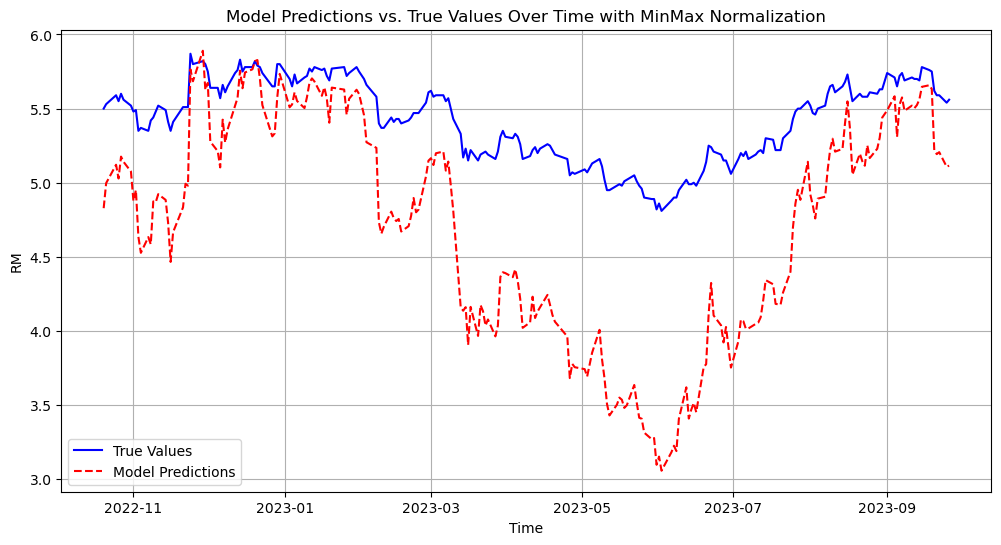

In [88]:
# Create the plot and check accuracy
print("Model Coefficients:", lr_minmax_norm.coef_)
print("Mean Absolute Error:", mean_absolute_error(target_minmax_test, y_minmax_lr_norm))
print("Coefficient of Determination:", r2_score(target_minmax_test, y_minmax_lr_norm))
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_minmax_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_minmax_lr_norm, label='Model Predictions', linestyle='--', color='r')
#plt.plot(timescale_list, model_predictions_first, label='Model Predictions First', linestyle='-', color='y')
#plt.plot(timescale_list, X_test, label='Test Data Point', linestyle='-', color='y')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time with MinMax Normalization')
plt.legend()
plt.grid(True)
plt.show()

In [89]:
# LSTM Model 50 layers with dropout 2x sets to predict the output that we want using minmax normalized data
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(feature_minmax_train.shape[1], 1), activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(50))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics =['mean_absolute_error'])
lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 16, 50)            10400     
                                                                 
 dropout_5 (Dropout)         (None, 16, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
454/454 - 36s - loss: 1.2224 - mean_absolute_error: 0.4552 - 36s/epoch - 80ms/step
Epoch 2/30
454/454 - 12s - loss: 0.0815 - mean_absolute_error: 0.2048 - 12s/epoch - 26ms/step
Epoch 3/30
454/454 - 12s - loss: 0.0856 - mean_absolute_error: 0.2093 - 12s/epoch - 27ms/step
Epoch 4/30
454/454 - 14s - loss: 0.0890 - mean_absolute_error: 0.2139 - 14s/epoch - 31ms/step
Epoch 5/30
454/454 - 12s - loss: 0.0952 - mean_absolute_error: 0.2216 - 12s/epoch - 27ms/step
Epoch 6/30
454/454 - 12s - loss: 0.1001 - mean_absolute_error: 0.2317 - 12s/epoch - 26ms/step
Epoch 7/30
454/454 - 12s - loss: 0.1048 - mean_absolute_error: 0.2364 - 12s/epoch - 26ms/step
Epoch 8/30
454/454 - 12s - loss: 0.1022 - mean_absolute_error: 0.2348 - 12s/epoch - 26ms/step
Epoch 9/30
454/454 - 11s - loss: 0.1096 - mean_absolute_error: 0.2416 - 11s/epoch - 25ms/step
Epoch 10/30
454/454 - 11s - loss: 0.1057 - mean_absolute_error: 0.2331 - 11s/epoch - 23ms/step
Epoch 11/30
454/454 - 10s - loss: 0.1077 - mean_absolute_er

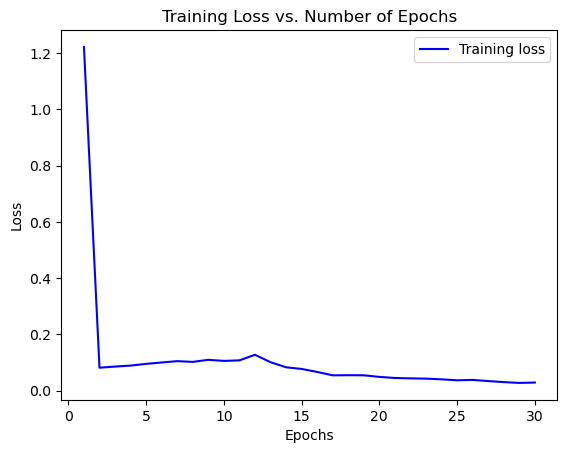

In [90]:
#Try to fit this simple model to the training data
history = lstm.fit(feature_minmax_train ,target_minmax_train, epochs=30, batch_size=2, verbose=2, shuffle=False)

# Assuming 'history' contains the training history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
#Predict the output
y_pred_lstm_norm = lstm.predict(feature_minmax_test)
print(y_pred_lstm_norm, y_pred_lstm_norm.shape)

8/8 [==============================] - 5s 20ms/step
[[5.3750153]
 [5.405595 ]
 [5.4453406]
 [5.4808936]
 [5.4278517]
 [5.5228734]
 [5.521916 ]
 [5.4252024]
 [5.476492 ]
 [5.4605155]
 [5.400363 ]
 [5.3965807]
 [5.3959475]
 [5.4308205]
 [5.4602323]
 [5.471226 ]
 [5.43106  ]
 [5.4137363]
 [5.3057413]
 [5.3275027]
 [5.3933415]
 [5.399164 ]
 [5.463871 ]
 [5.537093 ]
 [5.5590906]
 [5.5157394]
 [5.5003376]
 [5.534958 ]
 [5.5179358]
 [5.479865 ]
 [5.488027 ]
 [5.329786 ]
 [5.4680924]
 [5.39191  ]
 [5.510821 ]
 [5.5189776]
 [5.4927025]
 [5.5094643]
 [5.5332146]
 [5.5242867]
 [5.5481305]
 [5.5354457]
 [5.5311327]
 [5.569952 ]
 [5.5779133]
 [5.5279794]
 [5.5778766]
 [5.595177 ]
 [5.5902634]
 [5.3998733]
 [5.415777 ]
 [5.501297 ]
 [5.3907194]
 [5.468243 ]
 [5.4653144]
 [5.4893   ]
 [5.5026383]
 [5.5004034]
 [5.419386 ]
 [5.4196787]
 [5.395848 ]
 [5.4614244]
 [5.437922 ]
 [5.4018955]
 [5.25083  ]
 [5.144095 ]
 [5.261885 ]
 [5.3146534]
 [5.302368 ]
 [5.310832 ]
 [5.054796 ]
 [4.9261007]
 [4.915563 ]

RMSE:  0.41414171262810673
MAPE:  0.06463059265185447
Mean Absolute Error: 0.3415127577340551
Coefficient of Determination: -1.3413880122707376


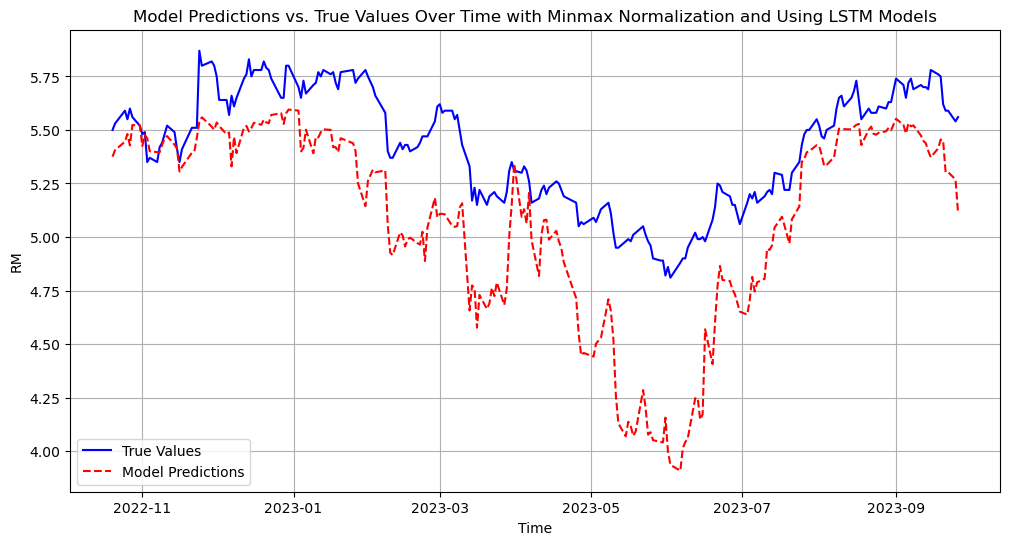

In [93]:
# Create the plot and check accuracy
rmse = mean_squared_error(target_minmax_test, y_pred_lstm_norm, squared=False)
mape = mean_absolute_percentage_error(target_minmax_test, y_pred_lstm_norm)
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("Mean Absolute Error:", mean_absolute_error(target_minmax_test, y_pred_lstm_norm))
print("Coefficient of Determination:", r2_score(target_minmax_test, y_pred_lstm_norm))
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_minmax_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_pred_lstm_norm, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time with Minmax Normalization and Using LSTM Models')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
sc_feature_train = StandardScaler()
feature_sc_train[feature_sc_train.columns] = sc_feature_train.fit_transform(feature_sc_train)
sc_feature_test = StandardScaler()
feature_sc_test[feature_sc_test.columns] = sc_feature_test.fit_transform(feature_sc_test)

Model Coefficients: [-3.97745031e-01  5.54224519e-01  5.52039181e-01 -3.67602053e-04
  5.47601399e-02  1.63727183e-03 -1.74586955e-03 -2.27113336e-03
 -1.01322912e-03 -9.34958121e-04  1.15615030e-02 -3.95720665e-03
 -4.10279297e-03 -4.15951273e-03 -3.75402908e-03 -3.60656444e-03]
Mean Absolute Error: 0.7231568936272867
Coefficient of Determination: -9.282968616531697


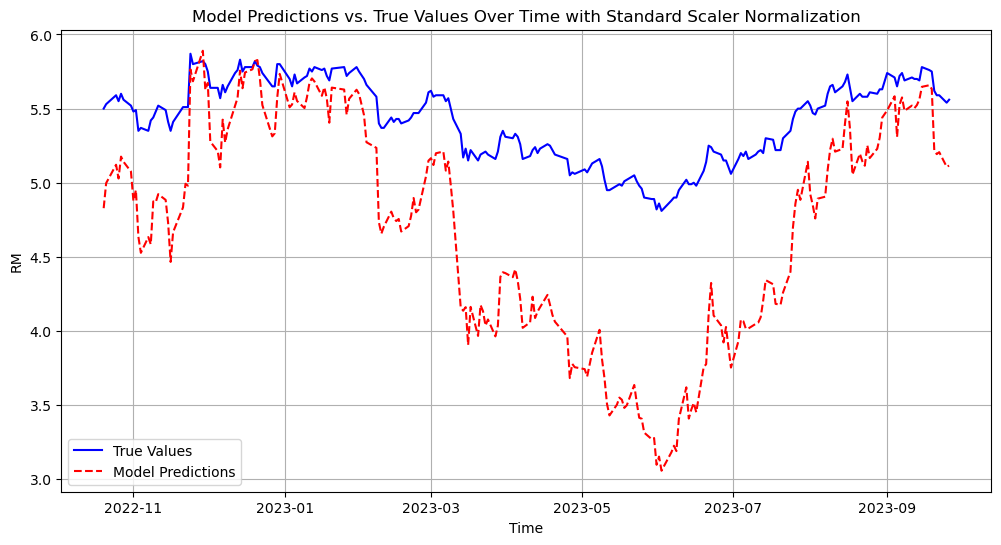

In [99]:
#Model Modelling using Sc normalized Data
lr_sc_norm = LinearRegression()
lr_sc_norm.fit(feature_sc_train, target_sc_train)
y_sc_lr_norm = lr_sc_norm.predict(feature_sc_test)
# Create the plot and check accuracy
print("Model Coefficients:", lr_sc_norm.coef_)
print("Mean Absolute Error:", mean_absolute_error(target_sc_test, y_sc_lr_norm))
print("Coefficient of Determination:", r2_score(target_sc_test, y_sc_lr_norm))
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_sc_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_sc_lr_norm, label='Model Predictions', linestyle='--', color='r')
#plt.plot(timescale_list, model_predictions_first, label='Model Predictions First', linestyle='-', color='y')
#plt.plot(timescale_list, X_test, label='Test Data Point', linestyle='-', color='y')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time with Standard Scaler Normalization')
plt.legend()
plt.grid(True)
plt.show()

## Model Logistic Regression training with minmax scalar and normalized data is both worse than non normalized data


In [165]:
less_features = X_feat.drop(['high-low','high-close', 'low-close','ATR', 'true_range', 'Volume'], axis=1)
less_features

,Open,High,Low,Close,SMA_20,RSI,SMA_50,Upper_fib_2618,Upper_fib_4236,Lower_fib_2618,Lower_fib_4236,SMA_30,SMA_40,SMA_10,SMA_5,SMA_8,Upper_fib_1618,Lower_fib_1618,Upper_fib_0618,Lower_fib_0618
Date,,,,,,,,,,,,,,,,,,,,
20181204,5.80,5.89,5.74,5.81,5.6745,67.816092,5.8052,6.10627,6.292340,5.50413,5.318060,5.679333,5.74875,5.739,5.814,5.76000,5.991270,5.619130,5.876270,5.734130
20181205,5.75,5.81,5.72,5.80,5.6805,67.045455,5.8006,6.10728,6.296817,5.49392,5.304383,5.673333,5.74275,5.753,5.824,5.78125,5.990137,5.611063,5.872994,5.728206
20181206,5.74,5.85,5.72,5.80,5.6865,63.291139,5.7966,6.10328,6.292817,5.48992,5.300383,5.675000,5.73675,5.768,5.814,5.79625,5.986137,5.607063,5.868994,5.724206
20181207,5.78,5.82,5.74,5.78,5.6910,58.666667,5.7914,6.09247,6.278540,5.49033,5.304260,5.677667,5.73525,5.783,5.818,5.80625,5.977470,5.605330,5.862470,5.720330
20181210,5.77,5.77,5.64,5.65,5.6950,45.000000,5.7838,6.08861,6.276991,5.47899,5.290609,5.680000,5.73500,5.780,5.768,5.79375,5.972181,5.595419,5.855753,5.711847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230920,5.58,5.64,5.55,5.62,5.6795,49.206349,5.5556,5.77626,5.912634,5.33494,5.198566,5.664667,5.62600,5.714,5.720,5.71375,5.691974,5.419226,5.607689,5.503511
20230921,5.63,5.64,5.57,5.59,5.6800,36.363636,5.5632,5.76890,5.896029,5.35750,5.230371,5.662667,5.62875,5.699,5.700,5.69875,5.690329,5.436071,5.611757,5.514643
20230922,5.58,5.62,5.56,5.59,5.6805,38.461538,5.5706,5.77817,5.906454,5.36303,5.234746,5.660333,5.63100,5.689,5.662,5.68500,5.698884,5.442316,5.619599,5.521601


In [166]:
#Prediction with negative correlations removed
training_size = round(len(less_features)*0.8)
train_less_features = less_features[:training_size]
test_less_features = less_features[training_size:]
target_less_features_train, feature_less_features_train = (train_less_features['Close'], train_less_features.drop(['Close'], axis = 1)) 
target_less_features_test, feature_less_features_test = (test_less_features['Close'], test_less_features.drop(['Close'], axis = 1)) 
print(less_features, target_less_features_train.shape, feature_less_features_train.shape, target_less_features_test.shape, feature_less_features_test.shape)


          Open  High   Low  Close  SMA_20        RSI  SMA_50  Upper_fib_2618  \
Date                                                                           
20181204  5.80  5.89  5.74   5.81  5.6745  67.816092  5.8052         6.10627   
20181205  5.75  5.81  5.72   5.80  5.6805  67.045455  5.8006         6.10728   
20181206  5.74  5.85  5.72   5.80  5.6865  63.291139  5.7966         6.10328   
20181207  5.78  5.82  5.74   5.78  5.6910  58.666667  5.7914         6.09247   
20181210  5.77  5.77  5.64   5.65  5.6950  45.000000  5.7838         6.08861   
...        ...   ...   ...    ...     ...        ...     ...             ...   
20230920  5.58  5.64  5.55   5.62  5.6795  49.206349  5.5556         5.77626   
20230921  5.63  5.64  5.57   5.59  5.6800  36.363636  5.5632         5.76890   
20230922  5.58  5.62  5.56   5.59  5.6805  38.461538  5.5706         5.77817   
20230925  5.59  5.60  5.54   5.54  5.6770  39.215686  5.5774         5.77749   
20230926  5.54  5.58  5.53   5.56  5.675

Mean Absolute Error: 0.01711310395675236
RMSE:  0.022503564434761213
MAPE:  0.0031484006993378415
R-Squared:  0.99308681678532


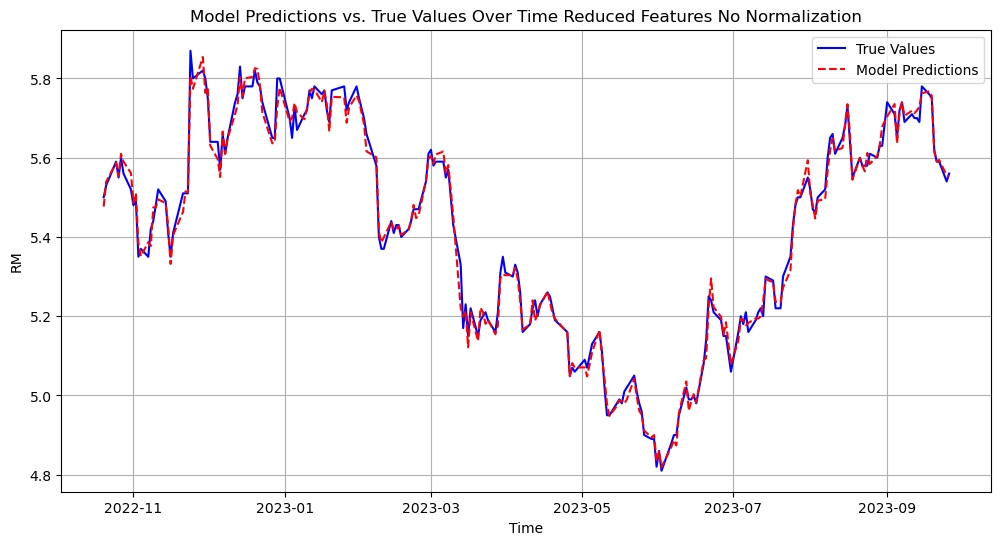

In [164]:
#Model Modelling
lr = LinearRegression()
lr.fit(feature_less_features_train ,target_less_features_train)
y_less_features_lr = lr.predict(feature_less_features_test)
# Create the plot and check accuracy
rmse = mean_squared_error(target_less_features_test, y_less_features_lr, squared=False)
mape = mean_absolute_percentage_error(target_less_features_test, y_less_features_lr)
r_squared = r2_score(target_less_features_test, y_less_features_lr)
print("Mean Absolute Error:", mean_absolute_error(target_less_features_test, y_less_features_lr))
print("RMSE: ", rmse)
print("MAPE: ", mape)
print('R-Squared: ', r_squared)
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_less_features_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_less_features_lr, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time Reduced Features No Normalization')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
# LSTM Model 50 layers with dropout 2x sets to predict the output that we want using minmax normalized data
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(feature_less_features_train.shape[1], 1), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics =['mean_absolute_error'])
lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50)                10400     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/30
454/454 - 8s - loss: 0.4362 - mean_absolute_error: 0.2700 - 8s/epoch - 17ms/step
Epoch 2/30
454/454 - 4s - loss: 0.0219 - mean_absolute_error: 0.1119 - 4s/epoch - 10ms/step
Epoch 3/30
454/454 - 4s - loss: 0.0172 - mean_absolute_error: 0.0983 - 4s/epoch - 10ms/step
Epoch 4/30
454/454 - 4s - loss: 0.0211 - mean_absolute_error: 0.1089 - 4s/epoch - 8ms/step
Epoch 5/30
454/454 - 5s - loss: 0.0255 - mean_absolute_error: 0.1133 - 5s/epoch - 11ms/step
Epoch 6/30
454/454 - 5s - loss: 0.0282 - mean_absolute_error: 0.1211 - 5s/epoch - 11ms/step
Epoch 7/30
454/454 - 5s - loss: 0.0337 - mean_absolute_error: 0.1334 - 5s/epoch - 10ms/step
Epoch 8/30
454/454 - 5s - loss: 0.0410 - mean_absolute_error: 0.1488 - 5s/epoch - 10ms/step
Epoch 9/30
454/454 - 5s - loss: 0.0456 - mean_absolute_error: 0.1608 - 5s/epoch - 11ms/step
Epoch 10/30
454/454 - 5s - loss: 0.0586 - mean_absolute_error: 0.1857 - 5s/epoch - 11ms/step
Epoch 11/30
454/454 - 4s - loss: 0.0628 - mean_absolute_error: 0.1939 - 4s/epoch

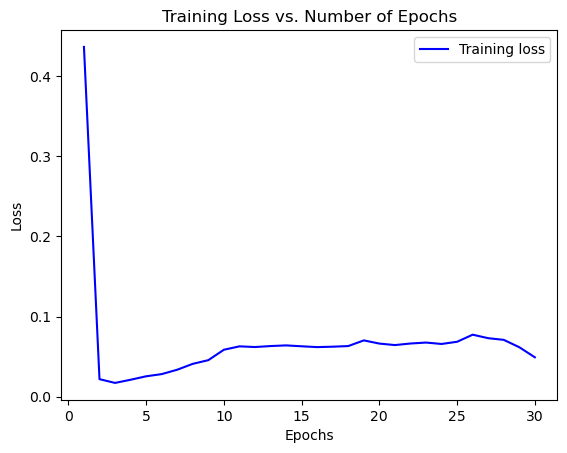

In [175]:
#Try to fit this simple model to the training data
history = lstm.fit(feature_less_features_train ,target_less_features_train, epochs=30, batch_size=2, verbose=2, shuffle=False)

# Assuming 'history' contains the training history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [176]:
#Predict the output
y_pred_lstm_less = lstm.predict(feature_less_features_test)
print(y_pred_lstm_less, y_pred_lstm_less.shape)

8/8 [==============================] - 1s 10ms/step
[[5.7832384]
 [5.8327117]
 [5.8659563]
 [5.7781773]
 [5.7901125]
 [5.74184  ]
 [5.7096114]
 [5.6440473]
 [5.6428275]
 [5.540922 ]
 [5.541932 ]
 [5.525663 ]
 [5.5770316]
 [5.522485 ]
 [5.483554 ]
 [5.4952164]
 [5.434755 ]
 [5.4117894]
 [5.333276 ]
 [5.4045687]
 [5.4929724]
 [5.518351 ]
 [5.5129657]
 [5.767807 ]
 [5.72343  ]
 [5.7494025]
 [5.726435 ]
 [5.6948986]
 [5.6222467]
 [5.608459 ]
 [5.5888834]
 [5.644994 ]
 [5.645038 ]
 [5.6357517]
 [5.6333733]
 [5.6449976]
 [5.670213 ]
 [5.500322 ]
 [5.5509114]
 [5.5437975]
 [5.576934 ]
 [5.5879607]
 [5.6485324]
 [5.619755 ]
 [5.6034446]
 [5.5482583]
 [5.6592903]
 [5.646972 ]
 [5.5365825]
 [5.495565 ]
 [5.5017557]
 [5.5094056]
 [5.5128903]
 [5.520467 ]
 [5.5275474]
 [5.532832 ]
 [5.5569615]
 [5.568475 ]
 [5.6256647]
 [5.592315 ]
 [5.4735665]
 [5.533083 ]
 [5.6045375]
 [5.5955296]
 [5.5551777]
 [5.637268 ]
 [5.5820255]
 [5.5335045]
 [5.459639 ]
 [5.41897  ]
 [5.294019 ]
 [5.2755594]
 [5.2526565]

RMSE:  0.22254340147959575
MAPE:  0.03504873038295642
Mean Absolute Error: 0.18600856823017944
Coefficient of Determination: 0.32390942186814886


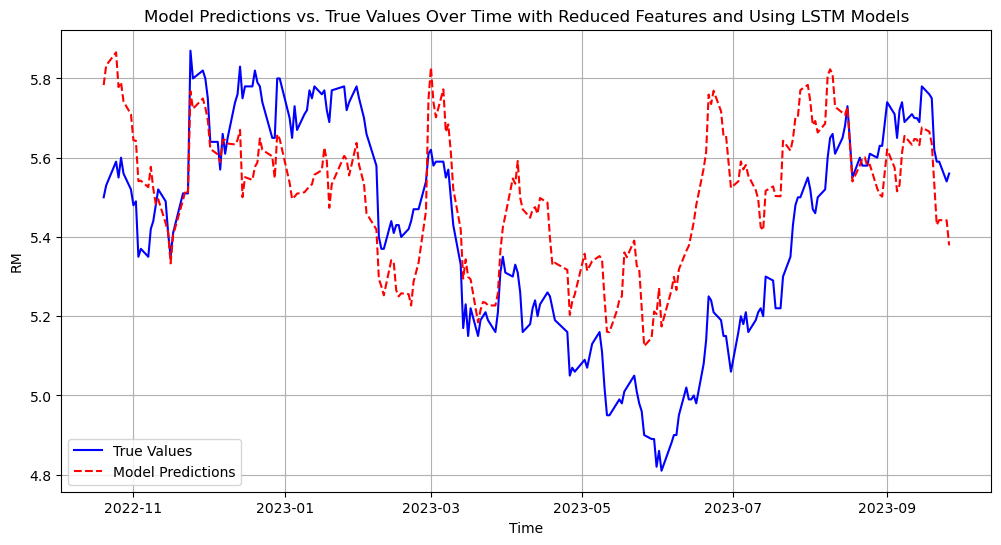

In [177]:
# Create the plot and check accuracy
rmse = mean_squared_error(target_less_features_test, y_pred_lstm_less, squared=False)
mape = mean_absolute_percentage_error(target_less_features_test, y_pred_lstm_less)
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("Mean Absolute Error:", mean_absolute_error(target_less_features_test, y_pred_lstm_less))
print("Coefficient of Determination:", r2_score(target_less_features_test, y_pred_lstm_less))
plt.figure(figsize=(12, 6))
plt.plot(timescale_list, target_less_features_test, label='True Values', linestyle='-', color='b')
plt.plot(timescale_list, y_pred_lstm_less, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title('Model Predictions vs. True Values Over Time with Reduced Features and Using LSTM Models')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l1
from keras.regularizers import l2
stock_data = pd.read_excel('./latest_cimb_test.xlsx', index_col='Date')
stock_data.head()

,ID,Name,Open,High,Low,Close,Volume
Date,,,,,,,
20180924,1023,CIMB,6.02,6.06,6.02,6.03,17108800
20180925,1023,CIMB,6.02,6.02,5.99,6.00,24703500
20180926,1023,CIMB,6.01,6.08,6.00,6.04,14643900
20180927,1023,CIMB,6.04,6.06,6.01,6.03,9278500
20180928,1023,CIMB,6.05,6.08,5.94,6.01,11639700


In [87]:
# Transform and calculate additional datapoints to feed into model

#Simple Moving Average (SMA) Calculation
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['SMA_40'] = stock_data['Close'].rolling(window=40).mean()
stock_data

# Average True Range (ATR) Calculation
stock_data['high-low'] = stock_data['High'] - stock_data['Low']
stock_data['high-close'] = abs(stock_data['High'] - stock_data['Close'].shift())
stock_data['low-close'] = abs(stock_data['Low'] - stock_data['Close'].shift())
stock_data['true_range'] = stock_data[['high-low', 'high-close', 'low-close']].max(axis=1)
stock_data['ATR'] = stock_data['true_range'].rolling(window=14).mean()
stock_data

#Relative Strength Index (RSI) Calculation
delta = stock_data['Close'].diff()
up = delta.where(delta > 0, 0)
down = -delta.where(delta < 0, 0)
avg_gain = up.rolling(window=14).mean()
avg_loss = down.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))
stock_data

#Fibonacci Calculation, there are upper and lower bands of fibonacci bands to calculate
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Upper_fib_2618'] = stock_data['SMA_50'] + stock_data['ATR'] * 2.618
stock_data['Upper_fib_4236'] = stock_data['SMA_50'] + stock_data['ATR'] * 4.236
stock_data['Lower_fib_2618'] = stock_data['SMA_50'] - stock_data['ATR'] * 2.618
stock_data['Lower_fib_4236'] = stock_data['SMA_50'] - stock_data['ATR'] * 4.236
stock_data['Upper_fib_1618'] = stock_data['SMA_50'] + stock_data['ATR'] * 1.618
stock_data['Lower_fib_1618'] = stock_data['SMA_50'] + stock_data['ATR'] * 1.618
stock_data['Upper_fib_0618'] = stock_data['SMA_50'] + stock_data['ATR'] * 0.618
stock_data['Lower_fib_0618'] = stock_data['SMA_50'] + stock_data['ATR'] * 0.618

stock_data

#Remove Rows with NaN values
data_only = stock_data[~stock_data.isna().any(axis=1)]
data_only.count()

#Sets a target 
target_y = data_only['Close']

#Splits out Non Values to get the features
X_feat = data_only.drop(['Close','ID', 'Name'], axis=1)
X_feat

,Open,High,Low,Volume,SMA_10,SMA_20,SMA_30,SMA_40,high-low,high-close,...,RSI,SMA_50,Upper_fib_2618,Upper_fib_4236,Lower_fib_2618,Lower_fib_4236,Upper_fib_1618,Lower_fib_1618,Upper_fib_0618,Lower_fib_0618
Date,,,,,,,,,,,,,,,,,,,,,
20181204,5.80,5.89,5.74,9736900,5.739,5.6745,5.679333,5.74875,0.15,0.01,...,67.816092,5.8052,6.10627,6.292340,5.50413,5.318060,5.991270,5.991270,5.876270,5.876270
20181205,5.75,5.81,5.72,7594800,5.753,5.6805,5.673333,5.74275,0.09,0.00,...,67.045455,5.8006,6.10728,6.296817,5.49392,5.304383,5.990137,5.990137,5.872994,5.872994
20181206,5.74,5.85,5.72,7127200,5.768,5.6865,5.675000,5.73675,0.13,0.05,...,63.291139,5.7966,6.10328,6.292817,5.48992,5.300383,5.986137,5.986137,5.868994,5.868994
20181207,5.78,5.82,5.74,6265100,5.783,5.6910,5.677667,5.73525,0.08,0.02,...,58.666667,5.7914,6.09247,6.278540,5.49033,5.304260,5.977470,5.977470,5.862470,5.862470
20181210,5.77,5.77,5.64,6568600,5.780,5.6950,5.680000,5.73500,0.13,0.01,...,45.000000,5.7838,6.08861,6.276991,5.47899,5.290609,5.972181,5.972181,5.855753,5.855753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230920,5.58,5.64,5.55,10520600,5.714,5.6795,5.664667,5.62600,0.09,0.11,...,49.206349,5.5556,5.77626,5.912634,5.33494,5.198566,5.691974,5.691974,5.607689,5.607689
20230921,5.63,5.64,5.57,13143300,5.699,5.6800,5.662667,5.62875,0.07,0.02,...,36.363636,5.5632,5.76890,5.896029,5.35750,5.230371,5.690329,5.690329,5.611757,5.611757
20230922,5.58,5.62,5.56,8715000,5.689,5.6805,5.660333,5.63100,0.06,0.03,...,38.461538,5.5706,5.77817,5.906454,5.36303,5.234746,5.698884,5.698884,5.619599,5.619599


In [88]:
X_feat['Close'] = target_y
X_feat = X_feat.drop(['Volume', 'high-low', 'high-close', 'low-close','ATR', 'true_range', 'SMA_40', 'SMA_30','Lower_fib_0618','Upper_fib_0618','Lower_fib_1618','Upper_fib_1618'], axis = 1)
dates = X_feat.index
X_feat

,Open,High,Low,SMA_10,SMA_20,RSI,SMA_50,Upper_fib_2618,Upper_fib_4236,Lower_fib_2618,Lower_fib_4236,Close
Date,,,,,,,,,,,,
20181204,5.80,5.89,5.74,5.739,5.6745,67.816092,5.8052,6.10627,6.292340,5.50413,5.318060,5.81
20181205,5.75,5.81,5.72,5.753,5.6805,67.045455,5.8006,6.10728,6.296817,5.49392,5.304383,5.80
20181206,5.74,5.85,5.72,5.768,5.6865,63.291139,5.7966,6.10328,6.292817,5.48992,5.300383,5.80
20181207,5.78,5.82,5.74,5.783,5.6910,58.666667,5.7914,6.09247,6.278540,5.49033,5.304260,5.78
20181210,5.77,5.77,5.64,5.780,5.6950,45.000000,5.7838,6.08861,6.276991,5.47899,5.290609,5.65
...,...,...,...,...,...,...,...,...,...,...,...,...
20230920,5.58,5.64,5.55,5.714,5.6795,49.206349,5.5556,5.77626,5.912634,5.33494,5.198566,5.62
20230921,5.63,5.64,5.57,5.699,5.6800,36.363636,5.5632,5.76890,5.896029,5.35750,5.230371,5.59
20230922,5.58,5.62,5.56,5.689,5.6805,38.461538,5.5706,5.77817,5.906454,5.36303,5.234746,5.59


In [89]:
def lstm_split(data, n_steps, n_target):
    X, y = [], []
    i = 0
    while i < (len(data) - n_steps - n_target + 1):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps:i + n_steps + n_target, -1])
        i += (n_steps + n_target) 
    return X, y

n_steps = 7
n_target = 1

X, y = lstm_split(X_feat.values, n_steps, n_target)

print(len(X))
print(len(y))
#Split the training and test data
train_split = 0.8
split_idx = int(np.ceil(len(X)*train_split))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print("X_train, X_test : ", len(X_train), len(X_test))
print("y_train, y_test : ", len(y_train), len(y_test))

def lstm_date_split(data, n_steps, n_target):
    X, y = [], []
    i = 0
    while i < (len(data) - n_steps - n_target+1):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps:i + n_steps + n_target])
        i += (n_steps + n_target) 
    return X, y

X_dates, y_dates = lstm_date_split(dates, n_steps, n_target)

print(len(X_dates))
print(len(y_dates))
train_split = 0.8
split_idx = int(np.ceil(len(X_dates)*train_split))
X_train_dates, X_test_dates = X_dates[:split_idx], X_dates[split_idx:]
y_train_dates, y_test_dates = y_dates[:split_idx], y_dates[split_idx:]
print("X_train_dates, X_test_dates : ", len(X_train_dates), len(X_test_dates))
print("y_train_dates, y_test_dates : ", len(y_train_dates), len(y_test_dates))

# Convert Data into Numpy Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(y_train.shape)

141
141
X_train, X_test :  113 28
y_train, y_test :  113 28
141
141
X_train_dates, X_test_dates :  113 28
y_train_dates, y_test_dates :  113 28
(113, 1)


Epoch 1/600
4/4 [==============================] - 28s 2s/step - loss: 20.6354 - val_loss: 31.4978
Epoch 2/600
4/4 [==============================] - 0s 99ms/step - loss: 14.7812 - val_loss: 28.7454
Epoch 3/600
4/4 [==============================] - 0s 107ms/step - loss: 8.6634 - val_loss: 24.4335
Epoch 4/600
4/4 [==============================] - 1s 131ms/step - loss: 5.7011 - val_loss: 21.3898
Epoch 5/600
4/4 [==============================] - 0s 127ms/step - loss: 4.4329 - val_loss: 19.9597
Epoch 6/600
4/4 [==============================] - 0s 95ms/step - loss: 3.5336 - val_loss: 19.2013
Epoch 7/600
4/4 [==============================] - 0s 101ms/step - loss: 3.0949 - val_loss: 18.3004
Epoch 8/600
4/4 [==============================] - 0s 96ms/step - loss: 3.4764 - val_loss: 17.5726
Epoch 9/600
4/4 [==============================] - 0s 99ms/step - loss: 3.0248 - val_loss: 16.8592
Epoch 10/600
4/4 [==============================] - 0s 97ms/step - loss: 2.8388 - val_loss: 16.2668
Epoc

Epoch 83/600
4/4 [==============================] - 0s 102ms/step - loss: 1.1150 - val_loss: 1.9321
Epoch 84/600
4/4 [==============================] - 0s 108ms/step - loss: 1.1018 - val_loss: 1.8467
Epoch 85/600
4/4 [==============================] - 0s 103ms/step - loss: 1.0942 - val_loss: 1.8000
Epoch 86/600
4/4 [==============================] - 0s 104ms/step - loss: 1.0990 - val_loss: 1.7506
Epoch 87/600
4/4 [==============================] - 0s 105ms/step - loss: 1.0698 - val_loss: 1.7534
Epoch 88/600
4/4 [==============================] - 1s 127ms/step - loss: 1.0804 - val_loss: 1.7106
Epoch 89/600
4/4 [==============================] - 1s 149ms/step - loss: 1.0689 - val_loss: 1.5545
Epoch 90/600
4/4 [==============================] - 1s 141ms/step - loss: 1.0556 - val_loss: 1.4870
Epoch 91/600
4/4 [==============================] - 0s 124ms/step - loss: 1.0436 - val_loss: 1.5487
Epoch 92/600
4/4 [==============================] - 0s 112ms/step - loss: 1.0271 - val_loss: 1.4600


4/4 [==============================] - 0s 101ms/step - loss: 0.5722 - val_loss: 0.5501
Epoch 165/600
4/4 [==============================] - 0s 97ms/step - loss: 0.5634 - val_loss: 0.5468
Epoch 166/600
4/4 [==============================] - 0s 101ms/step - loss: 0.5768 - val_loss: 0.5398
Epoch 167/600
4/4 [==============================] - 0s 106ms/step - loss: 0.5686 - val_loss: 0.5356
Epoch 168/600
4/4 [==============================] - 0s 101ms/step - loss: 0.5558 - val_loss: 0.5278
Epoch 169/600
4/4 [==============================] - 0s 98ms/step - loss: 0.5421 - val_loss: 0.5278
Epoch 170/600
4/4 [==============================] - 0s 101ms/step - loss: 0.5544 - val_loss: 0.5213
Epoch 171/600
4/4 [==============================] - 0s 100ms/step - loss: 0.5417 - val_loss: 0.5164
Epoch 172/600
4/4 [==============================] - 0s 97ms/step - loss: 0.5403 - val_loss: 0.5064
Epoch 173/600
4/4 [==============================] - 0s 99ms/step - loss: 0.5327 - val_loss: 0.5007
Epoch 17

4/4 [==============================] - 0s 106ms/step - loss: 0.3225 - val_loss: 0.2998
Epoch 246/600
4/4 [==============================] - 0s 102ms/step - loss: 0.3286 - val_loss: 0.2992
Epoch 247/600
4/4 [==============================] - 0s 97ms/step - loss: 0.3154 - val_loss: 0.2954
Epoch 248/600
4/4 [==============================] - 0s 94ms/step - loss: 0.3116 - val_loss: 0.2957
Epoch 249/600
4/4 [==============================] - 0s 98ms/step - loss: 0.3149 - val_loss: 0.2919
Epoch 250/600
4/4 [==============================] - 0s 98ms/step - loss: 0.3223 - val_loss: 0.2924
Epoch 251/600
4/4 [==============================] - 0s 96ms/step - loss: 0.3209 - val_loss: 0.2887
Epoch 252/600
4/4 [==============================] - 0s 101ms/step - loss: 0.3126 - val_loss: 0.2876
Epoch 253/600
4/4 [==============================] - 0s 98ms/step - loss: 0.3205 - val_loss: 0.2853
Epoch 254/600
4/4 [==============================] - 0s 103ms/step - loss: 0.3099 - val_loss: 0.2811
Epoch 255/

4/4 [==============================] - 0s 103ms/step - loss: 0.2062 - val_loss: 0.1833
Epoch 327/600
4/4 [==============================] - 0s 100ms/step - loss: 0.2284 - val_loss: 0.1823
Epoch 328/600
4/4 [==============================] - 0s 97ms/step - loss: 0.2137 - val_loss: 0.1877
Epoch 329/600
4/4 [==============================] - 0s 96ms/step - loss: 0.2054 - val_loss: 0.1915
Epoch 330/600
4/4 [==============================] - 0s 96ms/step - loss: 0.2073 - val_loss: 0.1858
Epoch 331/600
4/4 [==============================] - 0s 100ms/step - loss: 0.2043 - val_loss: 0.1811
Epoch 332/600
4/4 [==============================] - 0s 102ms/step - loss: 0.1968 - val_loss: 0.1802
Epoch 333/600
4/4 [==============================] - 0s 101ms/step - loss: 0.1912 - val_loss: 0.1798
Epoch 334/600
4/4 [==============================] - 0s 101ms/step - loss: 0.1971 - val_loss: 0.1795
Epoch 335/600
4/4 [==============================] - 0s 96ms/step - loss: 0.1947 - val_loss: 0.1843
Epoch 33

4/4 [==============================] - 0s 94ms/step - loss: 0.1492 - val_loss: 0.1291
Epoch 408/600
4/4 [==============================] - 0s 95ms/step - loss: 0.1525 - val_loss: 0.1290
Epoch 409/600
4/4 [==============================] - 0s 96ms/step - loss: 0.1476 - val_loss: 0.1276
Epoch 410/600
4/4 [==============================] - 0s 97ms/step - loss: 0.1506 - val_loss: 0.1264
Epoch 411/600
4/4 [==============================] - 0s 97ms/step - loss: 0.1462 - val_loss: 0.1277
Epoch 412/600
4/4 [==============================] - 0s 103ms/step - loss: 0.1514 - val_loss: 0.1245
Epoch 413/600
4/4 [==============================] - 0s 95ms/step - loss: 0.1549 - val_loss: 0.1242
Epoch 414/600
4/4 [==============================] - 0s 98ms/step - loss: 0.1475 - val_loss: 0.1260
Epoch 415/600
4/4 [==============================] - 0s 94ms/step - loss: 0.1518 - val_loss: 0.1283
Epoch 416/600
4/4 [==============================] - 0s 109ms/step - loss: 0.1426 - val_loss: 0.1237
Epoch 417/60

Epoch 489/600
4/4 [==============================] - 0s 94ms/step - loss: 0.1280 - val_loss: 0.0964
Epoch 490/600
4/4 [==============================] - 0s 98ms/step - loss: 0.1125 - val_loss: 0.0982
Epoch 491/600
4/4 [==============================] - 0s 94ms/step - loss: 0.1135 - val_loss: 0.0977
Epoch 492/600
4/4 [==============================] - 0s 100ms/step - loss: 0.1114 - val_loss: 0.0929
Epoch 493/600
4/4 [==============================] - 0s 95ms/step - loss: 0.1148 - val_loss: 0.0933
Epoch 494/600
4/4 [==============================] - 0s 95ms/step - loss: 0.1065 - val_loss: 0.0937
Epoch 495/600
4/4 [==============================] - 0s 93ms/step - loss: 0.1129 - val_loss: 0.0950
Epoch 496/600
4/4 [==============================] - 0s 101ms/step - loss: 0.1089 - val_loss: 0.0927
Epoch 497/600
4/4 [==============================] - 0s 98ms/step - loss: 0.1182 - val_loss: 0.0923
Epoch 498/600
4/4 [==============================] - 0s 95ms/step - loss: 0.1137 - val_loss: 0.092

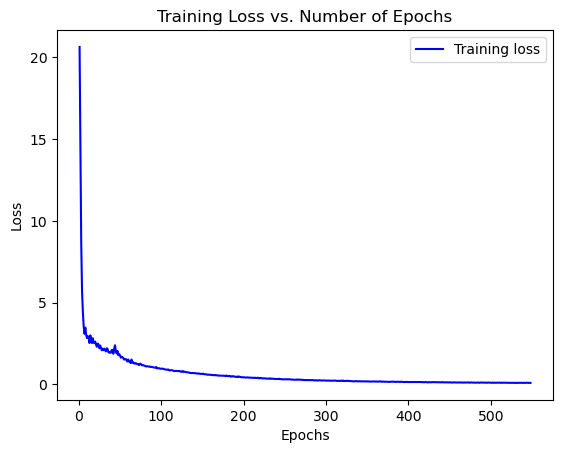

In [116]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.7))  # Add dropout for regularization
model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
model.add(Dense(128, activation='tanh', kernel_regularizer=l2(0.01)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.331575968))  # Add dropout for regularization
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())  # Add batch normalization for stability
model.add(Dense(16, activation='relu'))
model.add(Dense(n_target))

# Compile the model
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=600, validation_data=(X_test, y_test),verbose=1, shuffle=False, callbacks=[early_stopping])

# Assuming 'history' contains the training history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 6s 6s/step


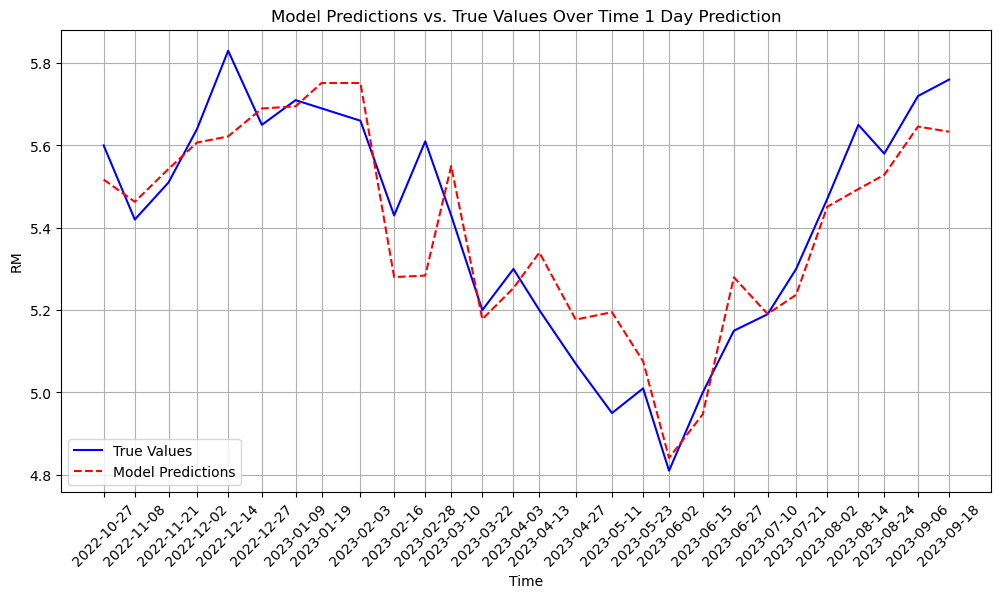

Mean Absolute Error: 0.09051418508802134
RMSE:  0.1169191354131872
MAPE:  0.016708967789282863
R-Squared:  0.8225546204675405


In [117]:
y_pred = model.predict(X_test)

formatted_dates = []

# Iterate through the date pairs and convert them
for date_pair in y_test_dates:
    formatted_pair = pd.to_datetime([str(date) for date in date_pair], format='%Y%m%d')
    formatted_dates.append(formatted_pair)

# Now you have a list of DatetimeIndex objects
formatted_dates = [pd.DatetimeIndex(pair) for pair in formatted_dates]

def flatten_index_list(index_list):
    # Initialize an empty list to store the flattened datetime values
    flattened_dates = []

    # Iterate through each Index object in the list
    for index in index_list:
        # Ensure the object is a Pandas Index
        if isinstance(index, pd.Index):
            # Convert the values in the Index to a list and extend the flattened_dates list
            flattened_dates.extend(index.tolist())
    
    return flattened_dates

flattened_dates = flatten_index_list(formatted_dates)
formatted_y_pred = y_pred.flatten()
flattened_y_test = np.array([item for sublist in y_test for item in sublist])

true_values = flattened_y_test
model_predictions = formatted_y_pred
plt.figure(figsize=(12, 6))
plt.plot(flattened_dates, true_values, label='True Values', linestyle='-', color='b')
plt.plot(flattened_dates, model_predictions, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title(f'Model Predictions vs. True Values Over Time {n_target} Day Prediction')
plt.legend()
# Set the x-axis labels to the formatted dates of the first list of date pairs
plt.xticks(flattened_dates, rotation=45) 
plt.grid(True)
plt.show()
rmse = mean_squared_error(true_values, model_predictions, squared=False)
mape = mean_absolute_percentage_error(true_values, model_predictions)
r_squared = r2_score(true_values, model_predictions)
print("Mean Absolute Error:", mean_absolute_error(true_values, model_predictions))
print("RMSE: ", rmse)
print("MAPE: ", mape)
print('R-Squared: ', r_squared)

In [138]:
def lstm_split(data, n_steps, n_target):
    X, y = [], []
    i = 0
    while i < (len(data) - n_steps - n_target):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps:i + n_steps + n_target, -1])
        i += (n_steps + n_target) 
    return X, y

n_steps = 7
n_target = 7

X, y = lstm_split(X_feat.values, n_steps, n_target)

print(len(X))
print(len(y))
#Split the training and test data
train_split = 0.8
split_idx = int(np.ceil(len(X)*train_split))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print("X_train, X_test : ", len(X_train), len(X_test))
print("y_train, y_test : ", len(y_train), len(y_test))

def lstm_date_split(data, n_steps, n_target):
    X, y = [], []
    i = 0
    while i < (len(data) - n_steps - n_target):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps:i + n_steps + n_target])
        i += (n_steps + n_target) 
    return X, y

X_dates, y_dates = lstm_date_split(dates, n_steps, n_target)

print(len(X_dates))
print(len(y_dates))
train_split = 0.8
split_idx = int(np.ceil(len(X_dates)*train_split))
X_train_dates, X_test_dates = X_dates[:split_idx], X_dates[split_idx:]
y_train_dates, y_test_dates = y_dates[:split_idx], y_dates[split_idx:]
print("X_train_dates, X_test_dates : ", len(X_train_dates), len(X_test_dates))
print("y_train_dates, y_test_dates : ", len(y_train_dates), len(y_test_dates))

# Convert Data into Numpy Arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(y_train.shape)

80
80
X_train, X_test :  64 16
y_train, y_test :  64 16
80
80
X_train_dates, X_test_dates :  64 16
y_train_dates, y_test_dates :  64 16
(64, 7)


Epoch 1/300
2/2 [==============================] - 29s 7s/step - loss: 22.1981 - val_loss: 25.0430
Epoch 2/300
2/2 [==============================] - 0s 168ms/step - loss: 15.9863 - val_loss: 22.0996
Epoch 3/300
2/2 [==============================] - 0s 117ms/step - loss: 12.3313 - val_loss: 19.9932
Epoch 4/300
2/2 [==============================] - 0s 111ms/step - loss: 10.2921 - val_loss: 18.6427
Epoch 5/300
2/2 [==============================] - 0s 214ms/step - loss: 9.0540 - val_loss: 17.1094
Epoch 6/300
2/2 [==============================] - 0s 136ms/step - loss: 4.6210 - val_loss: 14.2653
Epoch 7/300
2/2 [==============================] - 0s 109ms/step - loss: 8.0869 - val_loss: 13.9164
Epoch 8/300
2/2 [==============================] - 0s 137ms/step - loss: 5.1717 - val_loss: 13.0709
Epoch 9/300
2/2 [==============================] - 0s 128ms/step - loss: 2.8298 - val_loss: 11.5805
Epoch 10/300
2/2 [==============================] - 0s 97ms/step - loss: 3.0396 - val_loss: 11.193

2/2 [==============================] - 0s 92ms/step - loss: 0.7207 - val_loss: 2.1756
Epoch 84/300
2/2 [==============================] - 0s 107ms/step - loss: 0.6483 - val_loss: 2.1064
Epoch 85/300
2/2 [==============================] - 0s 95ms/step - loss: 0.6851 - val_loss: 2.0278
Epoch 86/300
2/2 [==============================] - 0s 90ms/step - loss: 0.7465 - val_loss: 1.9959
Epoch 87/300
2/2 [==============================] - 0s 97ms/step - loss: 0.6687 - val_loss: 1.9405
Epoch 88/300
2/2 [==============================] - 0s 103ms/step - loss: 0.7634 - val_loss: 1.9329
Epoch 89/300
2/2 [==============================] - 0s 94ms/step - loss: 0.7383 - val_loss: 1.9119
Epoch 90/300
2/2 [==============================] - 0s 97ms/step - loss: 0.6556 - val_loss: 1.8272
Epoch 91/300
2/2 [==============================] - 0s 98ms/step - loss: 0.6432 - val_loss: 1.7615
Epoch 92/300
2/2 [==============================] - 0s 94ms/step - loss: 0.6350 - val_loss: 1.7165
Epoch 93/300
2/2 [===

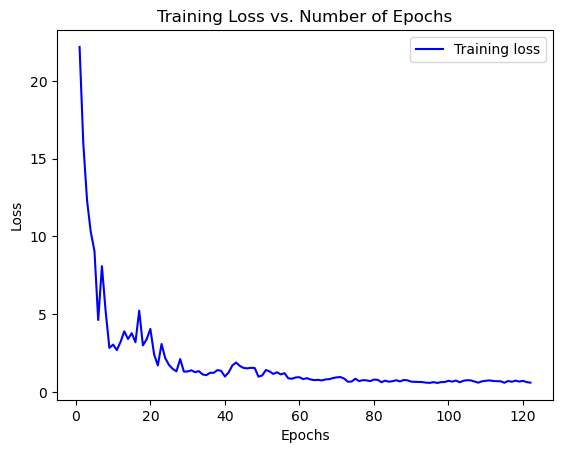

In [139]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.7))  # Add dropout for regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
model.add(Dense(64, activation='tanh', kernel_regularizer=l2(0.01)))
model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.6))  # Add dropout for regularization
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())  # Add batch normalization for stability
model.add(Dense(16, activation='relu'))
model.add(Dense(n_target))

# Compile the model
initial_learning_rate = 0.011
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test),verbose=1, shuffle=False, callbacks=[early_stopping])

# Assuming 'history' contains the training history
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 5s 5s/step


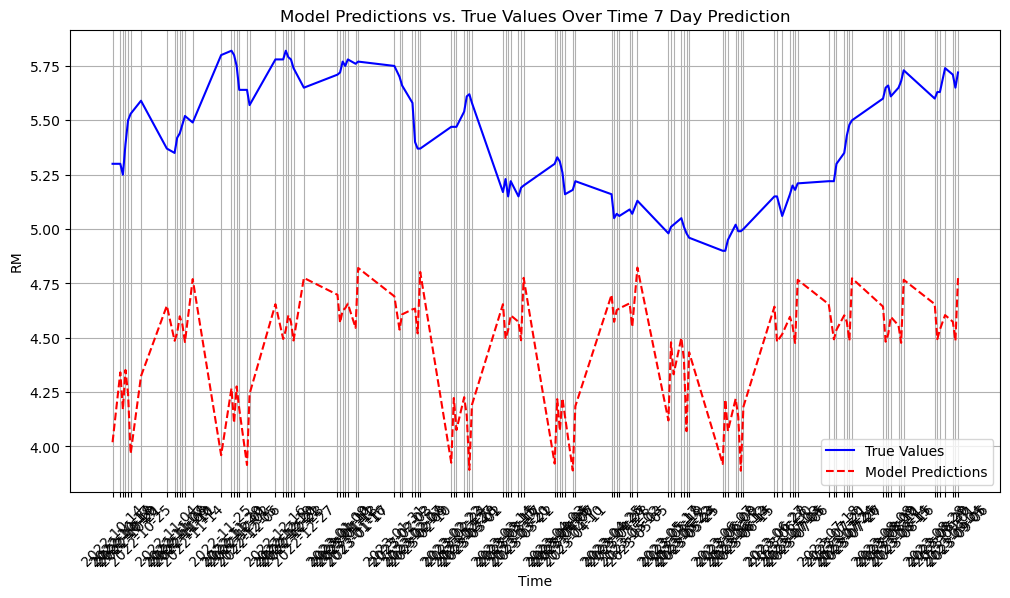

Mean Absolute Error: 0.9700890819515501
RMSE:  1.0252405822083122
MAPE:  0.17780101534522982
R-Squared:  -13.129134035267239


In [140]:
y_pred = model.predict(X_test)

formatted_dates = []

# Iterate through the date pairs and convert them
for date_pair in y_test_dates:
    formatted_pair = pd.to_datetime([str(date) for date in date_pair], format='%Y%m%d')
    formatted_dates.append(formatted_pair)

# Now you have a list of DatetimeIndex objects
formatted_dates = [pd.DatetimeIndex(pair) for pair in formatted_dates]

def flatten_index_list(index_list):
    # Initialize an empty list to store the flattened datetime values
    flattened_dates = []

    # Iterate through each Index object in the list
    for index in index_list:
        # Ensure the object is a Pandas Index
        if isinstance(index, pd.Index):
            # Convert the values in the Index to a list and extend the flattened_dates list
            flattened_dates.extend(index.tolist())
    
    return flattened_dates

flattened_dates = flatten_index_list(formatted_dates)
formatted_y_pred = y_pred.flatten()
flattened_y_test = np.array([item for sublist in y_test for item in sublist])

true_values = flattened_y_test
model_predictions = formatted_y_pred
plt.figure(figsize=(12, 6))
plt.plot(flattened_dates, true_values, label='True Values', linestyle='-', color='b')
plt.plot(flattened_dates, model_predictions, label='Model Predictions', linestyle='--', color='r')
plt.xlabel('Time')
plt.ylabel('RM')
plt.title(f'Model Predictions vs. True Values Over Time {n_target} Day Prediction')
plt.legend()
# Set the x-axis labels to the formatted dates of the first list of date pairs
plt.xticks(flattened_dates, rotation=45) 
plt.grid(True)
plt.show()
rmse = mean_squared_error(true_values, model_predictions, squared=False)
mape = mean_absolute_percentage_error(true_values, model_predictions)
r_squared = r2_score(true_values, model_predictions)
print("Mean Absolute Error:", mean_absolute_error(true_values, model_predictions))
print("RMSE: ", rmse)
print("MAPE: ", mape)
print('R-Squared: ', r_squared)

## Testing Model against current data to predict price change tomorrow and whether to buy or sell

In [189]:
stock_data = pd.read_excel('./latest_cimb_prices.xlsx')

#Transform and calculate additional datapoints to feed into model
#Simple Moving Average (SMA) Calculation
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['SMA_40'] = stock_data['Close'].rolling(window=40).mean()

# Average True Range (ATR) Calculation
stock_data['high-low'] = stock_data['High'] - stock_data['Low']
stock_data['high-close'] = abs(stock_data['High'] - stock_data['Close'].shift())
stock_data['low-close'] = abs(stock_data['Low'] - stock_data['Close'].shift())
stock_data['true_range'] = stock_data[['high-low', 'high-close', 'low-close']].max(axis=1)
stock_data['ATR'] = stock_data['true_range'].rolling(window=14).mean()

#Relative Strength Index (RSI) Calculation
delta = stock_data['Close'].diff()
up = delta.where(delta > 0, 0)
down = -delta.where(delta < 0, 0)
avg_gain = up.rolling(window=14).mean()
avg_loss = down.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

#Fibonacci Calculation, there are upper and lower bands of fibonacci bands to calculate
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Upper_fib_2618'] = stock_data['SMA_50'] + stock_data['ATR'] * 2.618
stock_data['Upper_fib_4236'] = stock_data['SMA_50'] + stock_data['ATR'] * 4.236
stock_data['Lower_fib_2618'] = stock_data['SMA_50'] - stock_data['ATR'] * 2.618
stock_data['Lower_fib_4236'] = stock_data['SMA_50'] - stock_data['ATR'] * 4.236
stock_data['Upper_fib_1618'] = stock_data['SMA_50'] + stock_data['ATR'] * 1.618
stock_data['Lower_fib_1618'] = stock_data['SMA_50'] + stock_data['ATR'] * 1.618
stock_data['Upper_fib_0618'] = stock_data['SMA_50'] + stock_data['ATR'] * 0.618
stock_data['Lower_fib_0618'] = stock_data['SMA_50'] + stock_data['ATR'] * 0.618

#Remove Rows with NaN values
data_only = stock_data[~stock_data.isna().any(axis=1)]
data_only.count()

two_weeks = stock_data.tail(16)
two_weeks

,Date,ID,Name,Open,High,Low,Close,Volume,SMA_10,SMA_20,...,RSI,SMA_50,Upper_fib_2618,Upper_fib_4236,Lower_fib_2618,Lower_fib_4236,Upper_fib_1618,Lower_fib_1618,Upper_fib_0618,Lower_fib_0618
1166,20230918,1023,CIMB,5.75,5.77,5.74,5.76,7805000,5.714,5.6700,...,65.384615,5.5352,5.73716,5.861977,5.33324,5.208423,5.660017,5.660017,5.582874,5.582874
1167,20230919,1023,CIMB,5.78,5.79,5.73,5.75,8423100,5.724,5.6775,...,62.000000,5.5470,5.74522,5.867726,5.34878,5.226274,5.669506,5.669506,5.593791,5.593791
1168,20230920,1023,CIMB,5.58,5.64,5.55,5.62,10520600,5.714,5.6795,...,49.206349,5.5556,5.77626,5.912634,5.33494,5.198566,5.691974,5.691974,5.607689,5.607689
1169,20230921,1023,CIMB,5.63,5.64,5.57,5.59,13143300,5.699,5.6800,...,36.363636,5.5632,5.76890,5.896029,5.35750,5.230371,5.690329,5.690329,5.611757,5.611757
1170,20230922,1023,CIMB,5.58,5.62,5.56,5.59,8715000,5.689,5.6805,...,38.461538,5.5706,5.77817,5.906454,5.36303,5.234746,5.698884,5.698884,5.619599,5.619599
1171,20230925,1023,CIMB,5.59,5.60,5.54,5.54,7969300,5.672,5.6770,...,39.215686,5.5774,5.77749,5.901151,5.37731,5.253649,5.701061,5.701061,5.624633,5.624633
1172,20230926,1023,CIMB,5.54,5.58,5.53,5.55,12927500,5.657,5.6745,...,31.111111,5.5824,5.76940,5.884971,5.39540,5.279829,5.697971,5.697971,5.626543,5.626543
1173,20230927,1023,CIMB,5.55,5.55,5.53,5.55,8701800,5.642,5.6705,...,27.906977,5.5876,5.76899,5.881094,5.40621,5.294106,5.699704,5.699704,5.630419,5.630419
1174,20230929,1023,CIMB,5.55,5.56,5.38,5.43,36339100,5.616,5.6605,...,24.000000,5.5918,5.79189,5.915551,5.39171,5.268049,5.715461,5.715461,5.639033,5.639033
1175,20231002,1023,CIMB,5.43,5.48,5.38,5.40,9387700,5.578,5.6435,...,19.607843,5.5954,5.80297,5.931254,5.38783,5.259546,5.723684,5.723684,5.644399,5.644399


In [202]:
input_data = two_weeks.drop(['ID', 'Name', 'Volume', 'high-low', 'high-close', 'low-close','ATR', 'true_range','SMA_40','SMA_30', 'Lower_fib_0618', 'Upper_fib_0618', 'Lower_fib_1618','Upper_fib_1618'], axis = 1)
input_data

,Date,Open,High,Low,Close,SMA_10,SMA_20,RSI,SMA_50,Upper_fib_2618,Upper_fib_4236,Lower_fib_2618,Lower_fib_4236
1166,20230918,5.75,5.77,5.74,5.76,5.714,5.6700,65.384615,5.5352,5.73716,5.861977,5.33324,5.208423
1167,20230919,5.78,5.79,5.73,5.75,5.724,5.6775,62.000000,5.5470,5.74522,5.867726,5.34878,5.226274
1168,20230920,5.58,5.64,5.55,5.62,5.714,5.6795,49.206349,5.5556,5.77626,5.912634,5.33494,5.198566
1169,20230921,5.63,5.64,5.57,5.59,5.699,5.6800,36.363636,5.5632,5.76890,5.896029,5.35750,5.230371
1170,20230922,5.58,5.62,5.56,5.59,5.689,5.6805,38.461538,5.5706,5.77817,5.906454,5.36303,5.234746
1171,20230925,5.59,5.60,5.54,5.54,5.672,5.6770,39.215686,5.5774,5.77749,5.901151,5.37731,5.253649
1172,20230926,5.54,5.58,5.53,5.55,5.657,5.6745,31.111111,5.5824,5.76940,5.884971,5.39540,5.279829
1173,20230927,5.55,5.55,5.53,5.55,5.642,5.6705,27.906977,5.5876,5.76899,5.881094,5.40621,5.294106
1174,20230929,5.55,5.56,5.38,5.43,5.616,5.6605,24.000000,5.5918,5.79189,5.915551,5.39171,5.268049
1175,20231002,5.43,5.48,5.38,5.40,5.578,5.6435,19.607843,5.5954,5.80297,5.931254,5.38783,5.259546


In [208]:
#input_data.set_index('Date', inplace=True)
#Gets the timescale of the test dates and also modify based on the step difference
timescale = input_data.index

# Change the format of the date
timescale_list = pd.to_datetime(timescale, format='%Y%m%d')
print(timescale_list)

split_dates = [timescale_list[7], timescale_list[15]]
print(split_dates)
dates_to_remove = ['2023-09-27', '2023-10-10']
timescale_list = timescale_list[~timescale_list.isin(dates_to_remove)]
print(timescale_list)

date_arrays = [timescale_list[:len(timescale_list)//2], timescale_list[len(timescale_list)//2:]]
date_arrays

DatetimeIndex(['2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-29', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-09', '2023-10-10'],
              dtype='datetime64[ns]', name='Date', freq=None)
[Timestamp('2023-09-27 00:00:00'), Timestamp('2023-10-10 00:00:00')]
DatetimeIndex(['2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-29',
               '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05',
               '2023-10-06', '2023-10-09'],
              dtype='datetime64[ns]', name='Date', freq=None)


[DatetimeIndex(['2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
                '2023-09-22', '2023-09-25', '2023-09-26'],
               dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex(['2023-09-29', '2023-10-02', '2023-10-03', '2023-10-04',
                '2023-10-05', '2023-10-06', '2023-10-09'],
               dtype='datetime64[ns]', name='Date', freq=None)]

In [220]:
target_y = input_data['Close']
input_data = input_data.drop(['Close'], axis = 1)
input_data['Close'] = target_y
def lstm_split(data, n_steps, n_target):
    X, y = [], []
    i = 0
    while i < (len(data) - n_steps - n_target+ 1):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps:i + n_steps + n_target, -1])
        i += (n_steps + n_target) 
    return X, y

n_steps = 7
n_target = 1

X, y = lstm_split(input_data.values, n_steps, n_target)

#Convert X and y into numpy arrays
X = np.array(X)
y = np.array(y)

In [223]:
from tensorflow.keras.models import load_model

anotherseventoonemodel = load_model('7to1pred_model.h5')

In [311]:
new_prediction = anotherseventoonemodel.predict(X)
print("Prediction: "+str(new_prediction))
print("Actual: "+str(y))

1/1 [==============================] - 0s 304ms/step
Prediction: [[5.504948 ]
 [5.2122593]]
Actual: [[5.55]
 [5.55]]


C:\Users\Jy\AppData\Local\Temp\ipykernel_4760\302435510.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



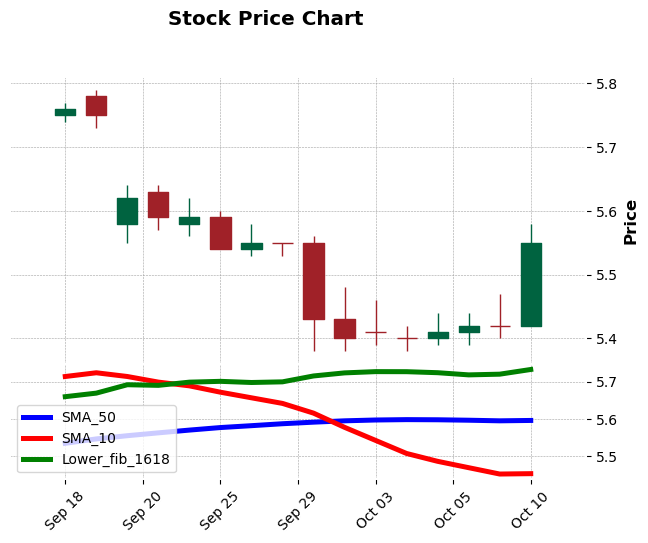

In [309]:
import mplfinance as mpf
data_plot = two_weeks[['Date', 'Open', 'High', 'Low','Close']]
#data_plot.set_index('Date', inplace=True)
data_plot['Date'] = pd.to_datetime(data_plot['Date'], format='%Y%m%d')  # Convert 'Date' column to datetime
data_plot.set_index('Date', inplace=True)  # Set 'Date' as the index
sma_50 = mpf.make_addplot(two_weeks['SMA_50'], panel=1, color='b', secondary_y=False, label='SMA_50')
sma_10 = mpf.make_addplot(two_weeks['SMA_10'], panel=1, color='r', secondary_y=False, label='SMA_10')
fib_band = mpf.make_addplot(two_weeks['Lower_fib_1618'], panel=1, color='g', secondary_y=False, label='Lower_fib_1618')

# Plot the candlestick chart with moving averages
mpf.plot(data_plot, type='candle', style='charles', title='Stock Price Chart', addplot=[sma_50, sma_10, fib_band])

## Using this as a guide and other indicators we can make better informed investments.
## I do not recommend using this on its own

In [ ]:
#Sample of how to run GridSearch CV for hyperparameter testing

def create_lstm_model(learning_rate=0.0014, dropout_rate=0.7, dense_units=128):
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(layers, return_sequences=True, activation='tanh')))
    model.add(Dense(dense_units, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(LSTM(64, return_sequences=True, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(32, return_sequences=False, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(16, activation=activation))
    model.add(Dense(n_target))

    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    return model
model = KerasRegressor(build_fn=create_lstm_model, dropout_rate=0.6, learning_rate=0.001, dense_units=64)
param_grid = {
    'learning_rate': [0.001, 0.0014, 0.0018],  # Experiment with learning rates
    'dropout_rate': [0.6, 0.7, 0.8, 0.5, 0.4],  # Experiment with dropout rates
    'dense_units': [64, 128, 256, 32, 16]  # Experiment with dense layer units
    'activation': ['tanh', 'relu'] # Experiment with activation 
    'layers': [16, 32, 64, 128, 256, 512] #Experiment with layer units
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

3/3 [==============================] - 13s 62ms/step - loss: 28.8143

Best Hyperparameters: {'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0018}